## Loading train and test files

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import xgboost as xgb
import sqlite3
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [1]:
import  pickle

with open('X_train.dat', 'rb') as infile:
    X_train = pickle.load(infile)

In [2]:
with open('X_test.dat', 'rb') as infile:
    X_test = pickle.load(infile)

In [3]:
import pandas as pd
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [4]:
print(X_test.shape)
print(X_train.shape)
print(y_train.shape) 
print(y_test.shape)

(30000, 626)
(70000, 626)
(70000, 1)
(30000, 1)


In [8]:
#https://stackoverflow.com/questions/33246771/convert-pandas-data-frame-to-series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

## Plot Confusion Matrix

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 

    labels = [1,2]
    # representing A in heatmap format

    print("-"*20, "Confusion matrix", "-"*20)

    plt.figure(figsize=(20,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,4))

    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format

    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,4))

    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8877783425109975
-------------------- Confusion matrix --------------------


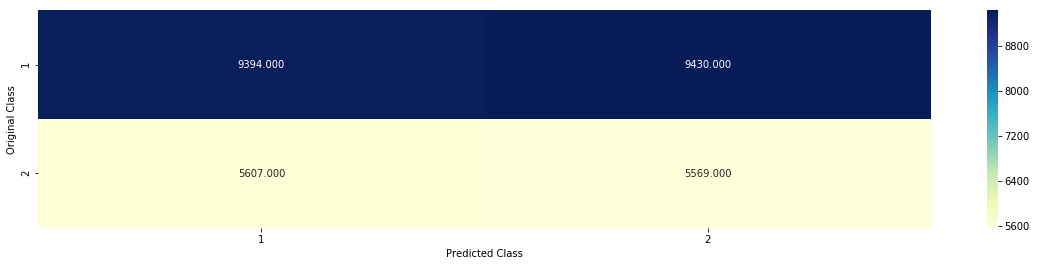

-------------------- Precision matrix (Columm Sum=1) --------------------


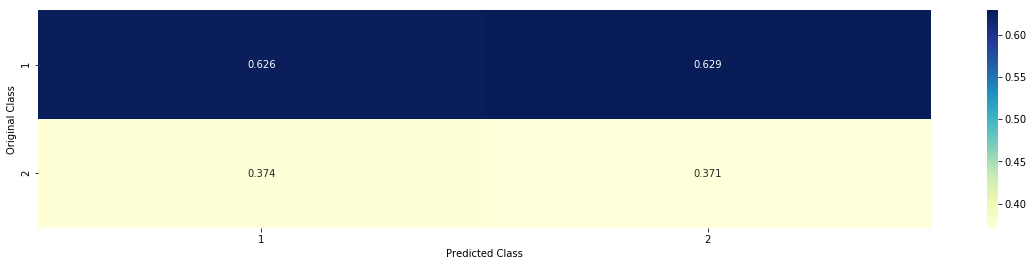

-------------------- Recall matrix (Row sum=1) --------------------


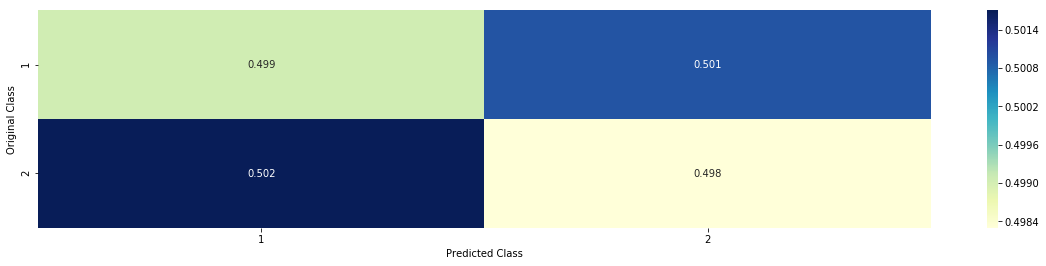

In [17]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data


test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Observation:
* The log loss of a dumb model is 0.88 which is the worst log loss that any random model could have.
* So now when we build a new model,we know that the log loss should be far less than 0.88 or between [0,0.88]

## Let's build proper models now

## Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.4543318801737719
For values of alpha =  0.0001 The log loss is: 0.4524782202772089
For values of alpha =  0.001 The log loss is: 0.46820424207236594
For values of alpha =  0.01 The log loss is: 0.52598585649691
For values of alpha =  0.1 The log loss is: 0.5173138778841347
For values of alpha =  1 The log loss is: 0.5704250579787771
For values of alpha =  10 The log loss is: 0.6465292164375275


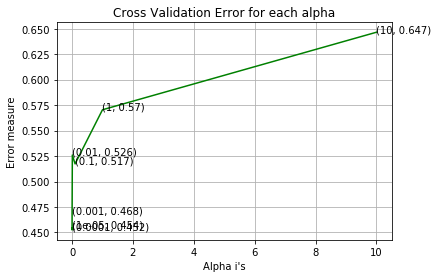

For values of best alpha =  0.0001 The train log loss is: 0.443409894599832
For values of best alpha =  0.0001 The test log loss is: 0.4524782202772089
Total number of data points : 30000
-------------------- Confusion matrix --------------------


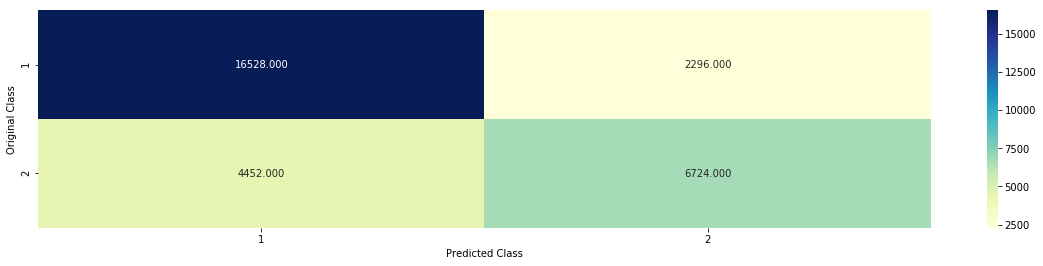

-------------------- Precision matrix (Columm Sum=1) --------------------


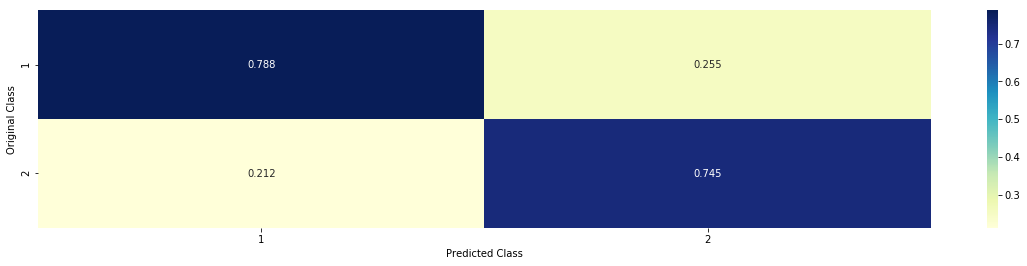

-------------------- Recall matrix (Row sum=1) --------------------


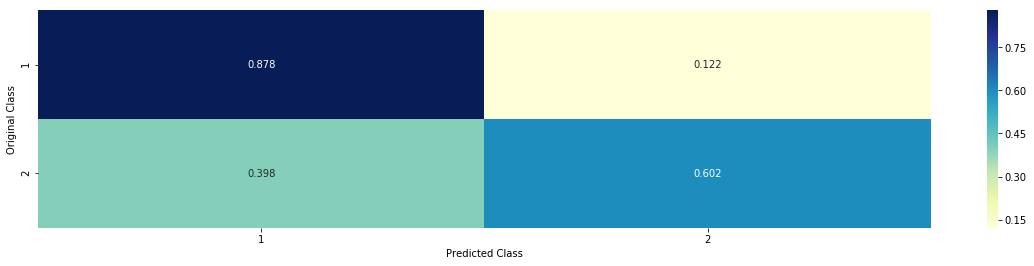

In [19]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression with hyperparameter tuning with L2 regularization(ridge)

For values of alpha =  1e-05 The log loss is: 0.420714599929964
For values of alpha =  0.0001 The log loss is: 0.41254310496598545
For values of alpha =  0.001 The log loss is: 0.4237732096766877
For values of alpha =  0.01 The log loss is: 0.44158693120125186
For values of alpha =  0.1 The log loss is: 0.45332105973194897
For values of alpha =  1 The log loss is: 0.49210499380153483
For values of alpha =  10 The log loss is: 0.5502185831370575


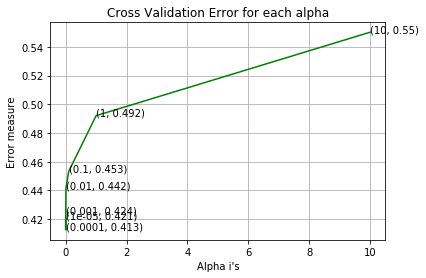

For values of best alpha =  0.0001 The train log loss is: 0.40412474217593003
For values of best alpha =  0.0001 The test log loss is: 0.41254310496598545
Total number of data points : 30000
-------------------- Confusion matrix --------------------


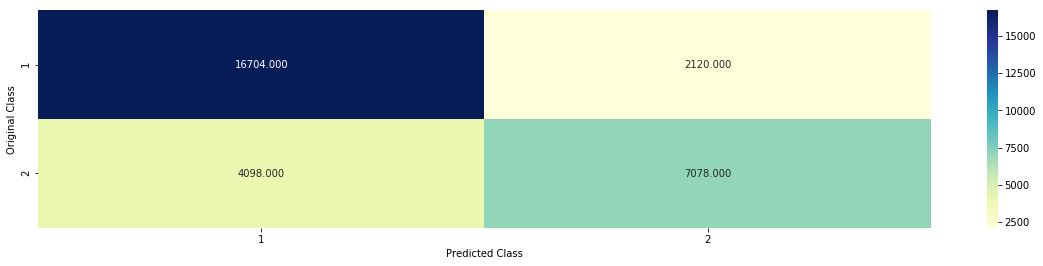

-------------------- Precision matrix (Columm Sum=1) --------------------


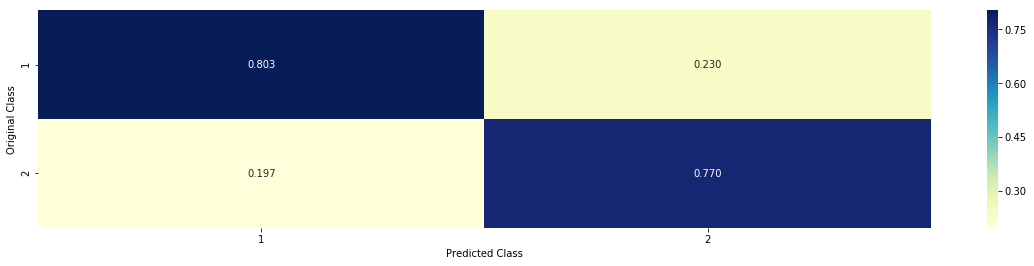

-------------------- Recall matrix (Row sum=1) --------------------


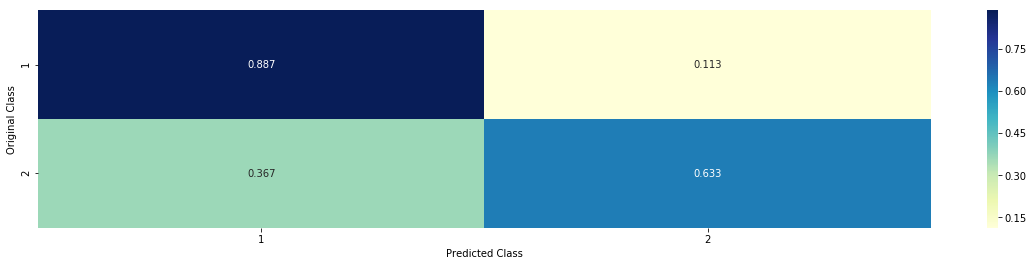

In [33]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGboost with hyperparameter tuning

In [22]:
depth = [1, 2, 3, 4]
n_est = [40, 80, 150, 600]
eta = [0.01,0.02,0.1,0.3]

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from tqdm import tqdm
xgb_gbdt = XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
grid_params = { 'max_depth':depth , 'n_estimators':n_est ,'eta':eta}
rs = RandomizedSearchCV(xgb_gbdt,grid_params ,cv=3, scoring='neg_log_loss')
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,


The best Hyperparameters are :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.02,
              eval_metric='logloss', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=600, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)
The test log loss is :  0.3267031109963563
The Train log loss is :  0.22605027031973132
-------------------- Confusion matrix --------------------


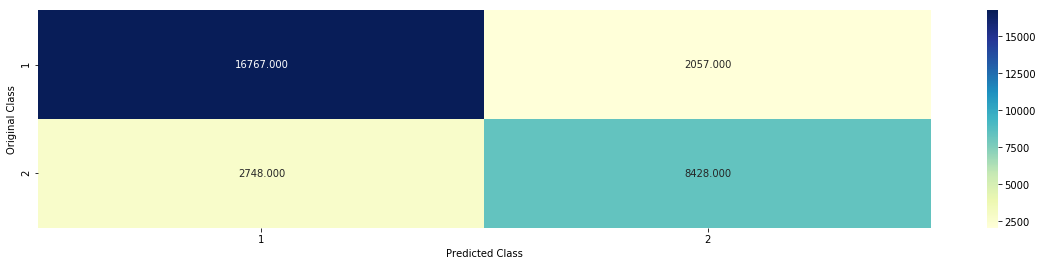

-------------------- Precision matrix (Columm Sum=1) --------------------


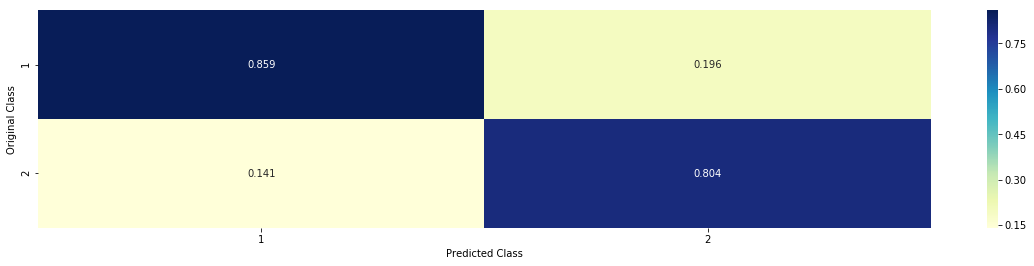

-------------------- Recall matrix (Row sum=1) --------------------


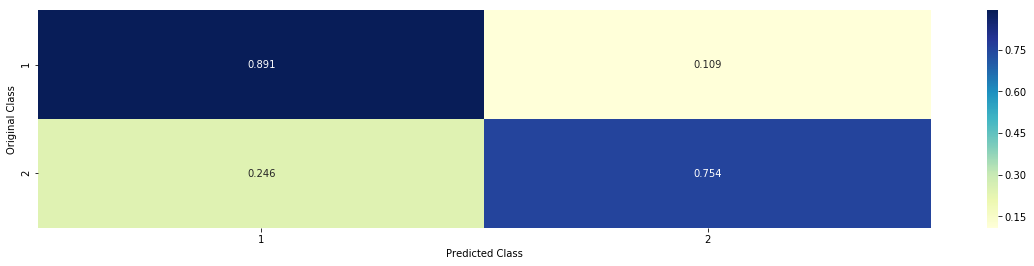

In [29]:
print("The best Hyperparameters are : ", rs.best_estimator_ )
print("The test log loss is : ",log_loss(y_test,rs.predict_proba(X_test)))
print("The Train log loss is : " ,log_loss(y_train , rs.predict_proba(X_train)))
plot_confusion_matrix(y_test, rs.predict(X_test))

In [36]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Test Log-Loss"]

x.add_row(["Random", 0.888])
x.add_row(["Logistic Regression(L2)", 0.41])
x.add_row(["Linear SVM", 0.446])
x.add_row(["XGBoost", 0.326])

print(x)

+-------------------------+---------------+
|          Model          | Test Log-Loss |
+-------------------------+---------------+
|          Random         |     0.888     |
| Logistic Regression(L2) |      0.41     |
|        Linear SVM       |     0.446     |
|         XGBoost         |     0.326     |
+-------------------------+---------------+


# Conclusion



*   Initially started by running a random model which produced a test loss of 0.88.
* So by that we understand that any sensible  model should perform significantly better than this. 
*   Tried Logistic Regression with hyperparameter tuning which led to test loss of 0.41 along with linear-SVM with hyperparameter tuning which led to test log-loss of 0.44.
*    Performed XGBoost with hyper-parameter using RandomizedSearchCV tuning to get a significant improvement over previous two models yielding a test loss of 0.326.
*   This is a significant improvement in log loss as compared to the logistic regression (with L2 regularizer) and linear SVM models.


*   Tuning the parameters of xgboost improves the model.






